# Análise perfil abstenção e comparecimento 1º turno - Eleiçoes 2022


## Objetivos

O projeto tem como objetivo identificar quais são os tipos de perfis dos eleitores que abstiveram nas eleições de 2022, periodo dessa análise ocorre somente com dados referente ao primeito turno.

Os perfis avaliados serão por gênero, idade e/ou faixa etária, nivel de escolaridade e quais regiões esses eleitores pertencem.


## Especificação Técnica

A base de dados utilizados estão disponiveis no site https://dadosabertos.tse.jus.br.

Link do arquivo:

https://cdn.tse.jus.br/estatistica/sead/odsele/perfil_comparecimento_abstencao/perfil_comparecimento_abstencao_2022.zip

Essa base de dados está em formato CSV


## Preparação dos dados

#### *Importação das principais para tratamento de dados*

In [1]:
import pandas as pd
import numpy as np

#### *Import da base de dados*

In [2]:
tb_eleicoes = pd.read_csv("dataset\perfil_comparecimento_abstencao_2022.csv",encoding="cp1252",sep=';')

#### *Filtro de colunas para trazer somente os dados necessários*

In [3]:
tb_eleicoes = tb_eleicoes[['SG_UF','NM_MUNICIPIO', 'DS_GENERO','CD_GENERO', 'DS_FAIXA_ETARIA',
          'DS_GRAU_ESCOLARIDADE', 'QT_APTOS','QT_COMPARECIMENTO','QT_ABSTENCAO']]

#### *Criando nova coluna, a partir de dados existentes*

Aqui foi utilizado a função Where, para criar uma condição em que selecionasse o estado e identificasse qual região pertence.

In [4]:
tb_eleicoes['Regiao'] = np.where(tb_eleicoes['SG_UF']=='ZZ','Exterior',
    np.where(tb_eleicoes['SG_UF']=='SC','Sul',
    np.where(tb_eleicoes['SG_UF']=='PR','Sul',
    np.where(tb_eleicoes['SG_UF']=='RS','Sul',
    np.where(tb_eleicoes['SG_UF']=='ES','Sudeste',
    np.where(tb_eleicoes['SG_UF']=='MG','Sudeste',
    np.where(tb_eleicoes['SG_UF']=='RJ','Sudeste',
    np.where(tb_eleicoes['SG_UF']=='SP','Sudeste',
    np.where(tb_eleicoes['SG_UF']=='DF','Centro_oeste',
    np.where(tb_eleicoes['SG_UF']=='GO','Centro_oeste',
    np.where(tb_eleicoes['SG_UF']=='MT','Centro_oeste',
    np.where(tb_eleicoes['SG_UF']=='MS','Centro_oeste',
    np.where(tb_eleicoes['SG_UF']=='AC','Norte', 
    np.where(tb_eleicoes['SG_UF']=='AP','Norte', 
    np.where(tb_eleicoes['SG_UF']=='AM','Norte', 
    np.where(tb_eleicoes['SG_UF']=='PA','Norte', 
    np.where(tb_eleicoes['SG_UF']=='RO','Norte',
    np.where(tb_eleicoes['SG_UF']=='RR','Norte',
    np.where(tb_eleicoes['SG_UF']=='TO','Norte', 'Nordeste'
    )))))))))))))))))))

In [5]:
tb_eleicoes['Codigo_regiao'] = np.where(tb_eleicoes['Regiao']== 'Exterior',1,
    np.where(tb_eleicoes['Regiao']== 'Sul',2,
    np.where(tb_eleicoes['Regiao']== 'Sudeste',3,
    np.where(tb_eleicoes['Regiao']== 'Centro_oeste',4,
    np.where(tb_eleicoes['Regiao']== 'Norte',5,6
            )))))

In [6]:
tb_eleicoes['Cod_idade'] = np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '16 anos',1,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '17 anos',2,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '18 anos',3,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '19 anos',4,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '20 anos',5,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '21 a 24 anos',6,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '25 a 29 anos',7,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '30 a 34 anos',8,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '35 a 39 anos',9,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '40 a 44 anos',10,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '45 a 49 anos',11,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '50 a 54 anos',12,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '55 a 59 anos',13,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '60 a 64 anos',14,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '65 a 69 anos',15,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '70 a 74 anos',16,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '75 a 79 anos',17,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '80 a 84 anos',18,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '85 a 89 anos',19,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '90 a 94 anos',20,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '95 a 99 anos',21,
    np.where(tb_eleicoes['DS_FAIXA_ETARIA']== '100 anos ou mais',22,0
    ))))))))))))))))))))))
tb_eleicoes.head()

,SG_UF,NM_MUNICIPIO,DS_GENERO,CD_GENERO,DS_FAIXA_ETARIA,DS_GRAU_ESCOLARIDADE,QT_APTOS,QT_COMPARECIMENTO,QT_ABSTENCAO,Regiao,Codigo_regiao,Cod_idade
0,AP,PRACUÚBA,MASCULINO,2,40 a 44 anos,ENSINO FUNDAMENTAL COMPLETO,10,7,3,Norte,5,10
1,AP,PRACUÚBA,MASCULINO,2,65 a 69 anos,ENSINO FUNDAMENTAL COMPLETO,2,2,0,Norte,5,15
2,AP,PRACUÚBA,MASCULINO,2,75 a 79 anos,ANALFABETO,2,0,2,Norte,5,17
3,AP,PRACUÚBA,MASCULINO,2,75 a 79 anos,ENSINO FUNDAMENTAL INCOMPLETO,1,0,1,Norte,5,17
4,AP,PRACUÚBA,MASCULINO,2,25 a 29 anos,ENSINO FUNDAMENTAL INCOMPLETO,1,1,0,Norte,5,7


#### *Renomeando os atributos*

In [7]:
tb_eleicoes = tb_eleicoes.rename(
    columns={
        'SG_UF': 'Estado',
        'NM_MUNICIPIO': 'Municipio',
        'DS_GENERO': 'Genero',
        'CD_GENERO': 'Codigo_genero',
        'DS_FAIXA_ETARIA': 'Faixa_etaria',
        'DS_GRAU_ESCOLARIDADE': 'Escolaridade',
        'CD_GRAU_ESCOLARIDADE': 'Codigo_escolaridade',
        'QT_APTOS': 'Aptos',
        'QT_COMPARECIMENTO': 'Comparecimento',
        'QT_ABSTENCAO': 'Abstencao',
    }
)
tb_eleicoes.head()

,Estado,Municipio,Genero,Codigo_genero,Faixa_etaria,Escolaridade,Aptos,Comparecimento,Abstencao,Regiao,Codigo_regiao,Cod_idade
0,AP,PRACUÚBA,MASCULINO,2,40 a 44 anos,ENSINO FUNDAMENTAL COMPLETO,10,7,3,Norte,5,10
1,AP,PRACUÚBA,MASCULINO,2,65 a 69 anos,ENSINO FUNDAMENTAL COMPLETO,2,2,0,Norte,5,15
2,AP,PRACUÚBA,MASCULINO,2,75 a 79 anos,ANALFABETO,2,0,2,Norte,5,17
3,AP,PRACUÚBA,MASCULINO,2,75 a 79 anos,ENSINO FUNDAMENTAL INCOMPLETO,1,0,1,Norte,5,17
4,AP,PRACUÚBA,MASCULINO,2,25 a 29 anos,ENSINO FUNDAMENTAL INCOMPLETO,1,1,0,Norte,5,7


#### *Validando as quantidades e somas campos dataset*

Trouxe a quantidade dos 26 Estados, mais DF e eleitores do Exterior *identificado pela abreviatura ZZ*

In [8]:
tb_eleicoes['Estado'].nunique()

28

In [9]:
tb_eleicoes['Aptos'].sum()

156454011

In [10]:
tb_eleicoes['Abstencao'].sum()

32716740

In [11]:
tb_eleicoes['Comparecimento'].sum()

123737271

In [12]:
data = [
    (156454011,32716740,123737271)
]  

tb_taxaeleicoes = pd.DataFrame(data, columns = ['Aptos','Abstencao','Compareceram'])

tb_taxaeleicoes['%Abstecao'] = (tb_taxaeleicoes['Abstencao']/tb_taxaeleicoes['Aptos'])*100
tb_taxaeleicoes['%Comparecimento'] = (tb_taxaeleicoes['Compareceram']/tb_taxaeleicoes['Aptos'])*100

tb_taxaeleicoes.head()

,Aptos,Abstencao,Compareceram,%Abstecao,%Comparecimento
0,156454011,32716740,123737271,20.91141,79.08859


Tivemos o total de 156.454.011 eleitores Aptos para votar.

Destes:

- 123.737.271 compareceram, 
- 32.716.740 se abstiveram.

Sendo uma taxa de 20,91% de abstenção.

Até aqui conseguimos verificar as quantidades e as taxas referente eleitores ativos e inativos durante o primeiro turno, porém seguiremos com uma anáise mais aprofundada, onde teremos uma visão minunciosa do perfil eleitorado, buscando assim entender quais fatores são os que mais indicam os motivos dessas abstenções.


Logo abaixo trago o tipo de dados de cada coluna, para poder executar os próximos passos.

In [13]:
tb_eleicoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392869 entries, 0 to 4392868
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Estado          object
 1   Municipio       object
 2   Genero          object
 3   Codigo_genero   int64 
 4   Faixa_etaria    object
 5   Escolaridade    object
 6   Aptos           int64 
 7   Comparecimento  int64 
 8   Abstencao       int64 
 9   Regiao          object
 10  Codigo_regiao   int32 
 11  Cod_idade       int32 
dtypes: int32(2), int64(4), object(6)
memory usage: 368.7+ MB


## Iniciando a analise estatística


### *Visão estatistica dos dados*

In [14]:
tb_eleicoes.describe().round()

,Codigo_genero,Aptos,Comparecimento,Abstencao,Codigo_regiao,Cod_idade
count,4392869.0,4392869.0,4392869.0,4392869.0,4392869.0,4392869.0
mean,3.0,36.0,28.0,7.0,4.0,12.0
std,1.0,126.0,105.0,25.0,2.0,5.0
min,0.0,1.0,0.0,0.0,1.0,0.0
25%,2.0,2.0,1.0,0.0,3.0,9.0
50%,4.0,5.0,3.0,1.0,3.0,13.0
75%,4.0,20.0,15.0,5.0,6.0,16.0
max,4.0,7187.0,5443.0,1744.0,6.0,22.0


Podemos ver que há 4.392.869 instâncias.
Média de comparecimento é de 28 e 7 para absenções



### *Calculando taxas*

#### *Essas taxas serão calculadas por*:

- Região,
- Genero,
- Faixa etária,
- Escolaridade.

In [15]:
turnover_rate = tb_eleicoes.Regiao.value_counts() / len(tb_eleicoes)

turnover_rate.round(3)

Sudeste         0.353
Nordeste        0.296
Sul             0.187
Centro_oeste    0.082
Norte           0.075
Exterior        0.008
Name: Regiao, dtype: float64

In [16]:
turnover_summary = tb_eleicoes.groupby('Regiao')
turnover_summary.sum()

D:\usuario\Suzy\AppData\Local\Temp\ipykernel_11008\4103618220.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  turnover_summary.sum()


,Codigo_genero,Aptos,Comparecimento,Abstencao,Codigo_regiao,Cod_idade
Regiao,,,,,,
Centro_oeste,1091480,11539323,9076598,2462725,1433288,4360525
Exterior,114430,697078,359120,337958,36919,421870
Nordeste,3971632,42390976,34115359,8275617,7788948,15639378
Norte,1002174,12560410,9930944,2629466,1649805,3942502
Sudeste,4680348,66707465,52060473,14646992,4648752,19745308
Sul,2509344,22558759,18194777,4363982,1639850,10061322


In [17]:
data = [
    ('Sudeste',66707465,14646992,52060473),
    ('Nordeste',42390976,8275617,34115359),
    ('Sul',22558759,4363982,18194777),
    ('Norte',12560410,2629466,9930944),
    ('Centro_oeste',11539323,2462725,9076598),
    ('Exterior',697078,337958,359120)
]  

tb_taxaregiao = pd.DataFrame(data, columns = ['Regiao','Aptos','Abstencao','Compareceram'])

tb_taxaregiao['%Abstecao'] = (tb_taxaregiao['Abstencao']/tb_taxaregiao['Aptos'])*100
tb_taxaregiao['%Comparecimento'] = (tb_taxaregiao['Compareceram']/tb_taxaregiao['Aptos'])*100

tb_taxaregiao.head(10)

,Regiao,Aptos,Abstencao,Compareceram,%Abstecao,%Comparecimento
0,Sudeste,66707465,14646992,52060473,21.957051,78.042949
1,Nordeste,42390976,8275617,34115359,19.522120,80.477880
2,Sul,22558759,4363982,18194777,19.344956,80.655044
3,Norte,12560410,2629466,9930944,20.934555,79.065445
4,Centro_oeste,11539323,2462725,9076598,21.342023,78.657977
5,Exterior,697078,337958,359120,48.482092,51.517908


Aqui podemos ver que as regiôes Sudeste e Nordeste são os que mais se destacam, onde:


- Sudeste detem de 35,3% do eleitorado, sendo a quantidade de 66.707.465 eleitores,
- Nordeste detem de 29,6% do eleitorado, sendo a quntidade de 42.390.96 eleitores,
- O eleitorado brasileiro que vota no exterior, foram os que mais se abstiveram tendo uma taxa de 48,5%,
- Sudeste teve a maior alta de abstenção com uma taxa de 21.9%,
- Sul possui a menor taxa de abstenção sendo 19.3%


Podemos concluir aqui, que as eleições do primeiro turno tiveram grande impacto nas Regiôes Sul, Sudeste e Nordeste.



### *Calculando taxa por genero*



In [18]:
turnover_rate = tb_eleicoes.Genero.value_counts() / len(tb_eleicoes)

turnover_rate.round(3)

FEMININO         0.526
MASCULINO        0.469
NÃO INFORMADO    0.005
Name: Genero, dtype: float64

In [19]:
turnover_summary = tb_eleicoes.groupby('Genero')
turnover_summary.sum()

D:\usuario\Suzy\AppData\Local\Temp\ipykernel_11008\3819511299.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  turnover_summary.sum()


,Codigo_genero,Aptos,Comparecimento,Abstencao,Codigo_regiao,Cod_idade
Genero,,,,,,
FEMININO,9250084,82373164,65945101,16428063,9061728,28380986
MASCULINO,4119324,74044065,57775813,16268252,8066916,25446598
NÃO INFORMADO,0,36782,16357,20425,68918,343321


In [20]:
data = [
    ('Feminino',82373164,16428063,65945101),
    ('Masculino',78044065,16288252,57775813),
    ('Não_declarado',36782,20425,16357)
]  

tb_taxagenero = pd.DataFrame(data, columns = ['Genero','Aptos','Abstencao','Compareceram'])

tb_taxagenero['%Abstecao'] = (tb_taxagenero['Abstencao']/tb_taxagenero['Aptos'])*100
tb_taxagenero['%Comparecimento'] = (tb_taxagenero['Compareceram']/tb_taxagenero['Aptos'])*100

tb_taxagenero.head()

,Genero,Aptos,Abstencao,Compareceram,%Abstecao,%Comparecimento
0,Feminino,82373164,16428063,65945101,19.943465,80.056535
1,Masculino,78044065,16288252,57775813,20.870584,74.029733
2,Não_declarado,36782,20425,16357,55.529879,44.470121


Entre os eleitores, a maior parte é composta pelas mulheres.

- São 52,6% do total, sendo 82,3 milhões aptas e tiveram a menor taxa de abstenção 19,9%.
- Já os homens são 78 milhões, 46,9% do total, tendo uma taxa de abstenção e 20,9%
- Outros 36,7 mil eleitores não decalaram gênero, e esses foram os que mais tiveram uma taxa de abstenção 55,5%.

Conclui-se aqui por esses dados, que as mulheres possuem hoje o grande poder de decidir sobre quem governara nosso país, em contra partida, as pessoas que se declaram transgênero, transexuais e travestis ainda não tem confiança em nossos candidatos, que eles de fato farão diferença em suas vidas.


#### *Calculando taxa por faixa etária***


In [21]:
turnover_rate = tb_eleicoes.Faixa_etaria.value_counts() / len(tb_eleicoes)

turnover_rate.round(3)

55 a 59 anos        0.082
60 a 64 anos        0.081
50 a 54 anos        0.078
65 a 69 anos        0.077
45 a 49 anos        0.074
40 a 44 anos        0.070
70 a 74 anos        0.069
35 a 39 anos        0.062
75 a 79 anos        0.058
30 a 34 anos        0.054
80 a 84 anos        0.048
25 a 29 anos        0.045
85 a 89 anos        0.036
21 a 24 anos        0.033
90 a 94 anos        0.026
20 anos             0.019
19 anos             0.018
95 a 99 anos        0.017
18 anos             0.017
17 anos             0.013
100 anos ou mais    0.010
16 anos             0.010
Inválido            0.000
Name: Faixa_etaria, dtype: float64

In [22]:
turnover_summary = tb_eleicoes.groupby('Faixa_etaria')
turnover_summary.sum()

D:\usuario\Suzy\AppData\Local\Temp\ipykernel_11008\1595850738.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  turnover_summary.sum()


,Codigo_genero,Aptos,Comparecimento,Abstencao,Codigo_regiao,Cod_idade
Faixa_etaria,,,,,,
100 anos ou mais,134614,184438,1685,182753,169626,997194
16 anos,135460,815063,682836,132227,186928,44749
17 anos,173732,1301718,1071853,229865,236813,114236
18 anos,225948,2060846,1780375,280471,297643,222471
19 anos,246882,2370336,1924838,445498,321752,321884
20 anos,259732,2610996,2070734,540262,337992,421990
21 a 24 anos,444596,12321272,9427293,2893979,570340,858516
25 a 29 anos,610034,15943517,12365986,3577531,786289,1385594
30 a 34 anos,724212,15554999,12472331,3082668,938883,1889816


In [23]:
data = [
        ('100 anos ou mais',184438,182753,1685),
        ('16 anos',815063,132227,682836),
        ('17 anos',1301718,229865,1071853),
        ('18 anos',2060846,280471,1780375),
        ('19 anos',2370336,445498,1924838),
        ('20 anos',2610996,540262,2070734),
        ('21 a 24 anos',12321272,2893979,9427293),
        ('25 a 29 anos',15943517,3577531,12365986),
        ('30 a 34 anos',15554999,3082668,12472331),
        ('35 a 39 anos',16142478,2788897,13353581),
        ('40 a 44 anos',16064565,2477101,13587464),
        ('45 a 49 anos',13869461,1933553,11935908),
        ('50 a 54 anos',12637077,1586805,11050272),
        ('55 a 59 anos',11868255,1413766,10454489),
        ('60 a 64 anos',9995705,1265617,8730088),
        ('65 a 69 anos',8002452,1302474,6699978),
        ('70 a 74 anos',5885358,2293841,3591517),
        ('75 a 79 anos',3858345,2244811,1613534),
        ('80 a 84 anos',2424573,1770470,654103),
        ('85 a 89 anos',1334866,1124971,209895),
        ('90 a 94 anos',738761,688960,49801),
        ('95 a 99 anos',466940,459325,7615),
        ('Inválido',1990,895,1095)
]  

tb_taxaidade = pd.DataFrame(data, columns = ['Faixa_etaria','Aptos','Abstencao','Compareceram'])

tb_taxaidade['%Abstecao'] = (tb_taxaidade['Abstencao']/tb_taxaidade['Aptos'])*100
tb_taxaidade['%Comparecimento'] = (tb_taxaidade['Compareceram']/tb_taxaidade['Aptos'])*100

tb_taxaidade.head(25)

,Faixa_etaria,Aptos,Abstencao,Compareceram,%Abstecao,%Comparecimento
0,100 anos ou mais,184438,182753,1685,99.086414,0.913586
1,16 anos,815063,132227,682836,16.222918,83.777082
2,17 anos,1301718,229865,1071853,17.658587,82.341413
3,18 anos,2060846,280471,1780375,13.609508,86.390492
4,19 anos,2370336,445498,1924838,18.794719,81.205281
5,20 anos,2610996,540262,2070734,20.691797,79.308203
6,21 a 24 anos,12321272,2893979,9427293,23.487664,76.512336
7,25 a 29 anos,15943517,3577531,12365986,22.438782,77.561218
8,30 a 34 anos,15554999,3082668,12472331,19.817860,80.182140
9,35 a 39 anos,16142478,2788897,13353581,17.276759,82.723241


O eleitorado acima de 70 anos não possui obrigatoridade de votação, assim como jovens entre 16 a 18 anos. Porém idoses entre 70 e mais de 100 anos, ainda são bastante partcipativos.

- A menor taxa de abstenção dentro da faixa etária que tem obrigatoriedade no voto, foi de 11,9% e está dentro da faixa etária dos 50 a 59 anos,
- Já a maior taxa entre eleitores que possuem a obrigatoriedade, está entre os jovens de 21 a 24 anos, 23,4% e a segunda maior entre 25 a 29 anos, 22,4%.
- A maior quantidade de eleitores está entre a faixa etárida de 35 a 39 anos, sendo 16,1 milhões.
- Os eleitores jovens que não possuem obrigatoriedade, se mantiveram em 80% de comparecimento.


Isso nos mostra que os eleitores estão cada vez mais cedo buscando fazer a diferença com suas escolhas, assim como os mais velhos acreditam ainda poder decidir sobre a escola dos governantes.

O artigo 14 capitulo 1 da constituição, dita que o voto é facultativo para analfabetos, maiores de 60 anoes e menores de 18 anos.

#### *Calculando taxa por escolaridade*

In [24]:
turnover_rate = tb_eleicoes.Escolaridade.value_counts() / len(tb_eleicoes)

turnover_rate.round(3)

ENSINO FUNDAMENTAL INCOMPLETO    0.168
ENSINO MÉDIO COMPLETO            0.147
LÊ E ESCREVE                     0.135
ENSINO FUNDAMENTAL COMPLETO      0.124
ENSINO MÉDIO INCOMPLETO          0.117
ANALFABETO                       0.116
SUPERIOR COMPLETO                0.108
SUPERIOR INCOMPLETO              0.082
NÃO INFORMADO                    0.004
Name: Escolaridade, dtype: float64

In [25]:
turnover_summary = tb_eleicoes.groupby('Escolaridade')
turnover_summary.sum()

D:\usuario\Suzy\AppData\Local\Temp\ipykernel_11008\1656397972.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  turnover_summary.sum()


,Codigo_genero,Aptos,Comparecimento,Abstencao,Codigo_regiao,Cod_idade
Escolaridade,,,,,,
ANALFABETO,1535696,6339894,3038062,3301832,2101290,7416545
ENSINO FUNDAMENTAL COMPLETO,1650072,10197034,7892909,2304125,2076766,6433714
ENSINO FUNDAMENTAL INCOMPLETO,2227226,35930401,27352970,8577431,2866624,9313866
ENSINO MÉDIO COMPLETO,1987696,41161552,34867918,6293634,2501946,7330187
ENSINO MÉDIO INCOMPLETO,1567872,26049309,20762685,5286624,1987287,5263407
LÊ E ESCREVE,1766498,11206893,7687660,3519233,2431494,8490254
NÃO INFORMADO,44978,32156,14734,17422,53440,262131
SUPERIOR COMPLETO,1480352,17127128,15009664,2117464,1809101,5864003
SUPERIOR INCOMPLETO,1109018,8409644,7110669,1298975,1369614,3796798


In [26]:
data = [
        ('Analfabeto',6339894,3301832,3038062),
        ('Ens_Fundamental_completo',10197034,2304125,7892909),
        ('Ens_Fundamental_incompleto',35930401,8577431,27352970),
        ('Ens_Medio_completo',41161552,6293634,34867918),
        ('Ens_Medio_incompleto',26049309,5286624,20762685),
        ('Lê e escreve',11206893,3519233,7687660),
        ('Não informado',32156,17422,14734),
        ('Superior_completo',17127128,2117464,15009664),
        ('Superior_incompleto',8409644,1298975,7110669)
]  

tb_taxaescolaridade = pd.DataFrame(data, columns = ['Escolaridade','Aptos','Abstencao','Compareceram'])

tb_taxaescolaridade['%Abstecao'] = (tb_taxaescolaridade['Abstencao']/tb_taxaescolaridade['Aptos'])*100
tb_taxaescolaridade['%Comparecimento'] = (tb_taxaescolaridade['Compareceram']/tb_taxaescolaridade['Aptos'])*100

tb_taxaescolaridade.head(25)

,Escolaridade,Aptos,Abstencao,Compareceram,%Abstecao,%Comparecimento
0,Analfabeto,6339894,3301832,3038062,52.080240,47.919760
1,Ens_Fundamental_completo,10197034,2304125,7892909,22.596031,77.403969
2,Ens_Fundamental_incompleto,35930401,8577431,27352970,23.872350,76.127650
3,Ens_Medio_completo,41161552,6293634,34867918,15.290079,84.709921
4,Ens_Medio_incompleto,26049309,5286624,20762685,20.294680,79.705320
5,Lê e escreve,11206893,3519233,7687660,31.402397,68.597603
6,Não informado,32156,17422,14734,54.179624,45.820376
7,Superior_completo,17127128,2117464,15009664,12.363217,87.636783
8,Superior_incompleto,8409644,1298975,7110669,15.446254,84.553746


Nessa última análise, notamos que a maior quantidade de elitorado, possui o ensino médio completo. Sendo um total de 41,1 milhões.

Também se nota que as menores taxas de abstenção ocorreram entre os eleitores que possuem um melhor grau de instrução:

- Quem possui o superio completo, foram os que tiveram a menor taxa de abstenção, 12,36%,
- Segudo por quem possui ensino médio completo, 15,29% de taxa asbtenção,
- E depois por quem possui superior incompleto, 15,44%.
- Já a maior taxa de abstenção foi 54,17% para quem não informou escolaridade.
- A segunda maior está entre os analfabetos 52,08%.

Finalizamos aqui com essa análise, e podemos concluir que ainda hoje, a ausência de escolaridade influencia e muito para que possamos decidir entre os melhores candidatos, pois 54,17% das abstenções ocorreram entre quem não declarou ter alguma escolaridade, 52,08% entre os analfabetos (lembrando que esses não possuem obrigatoriedade) e 31,4% entre quem somente lê e escreve.


## Análises

### Analisando correlações

In [27]:
import seaborn as sn
import matplotlib.pyplot as plt

D:\usuario\Suzy\AppData\Local\Temp\ipykernel_11008\4204524103.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = tb_eleicoes.corr()


<AxesSubplot: >

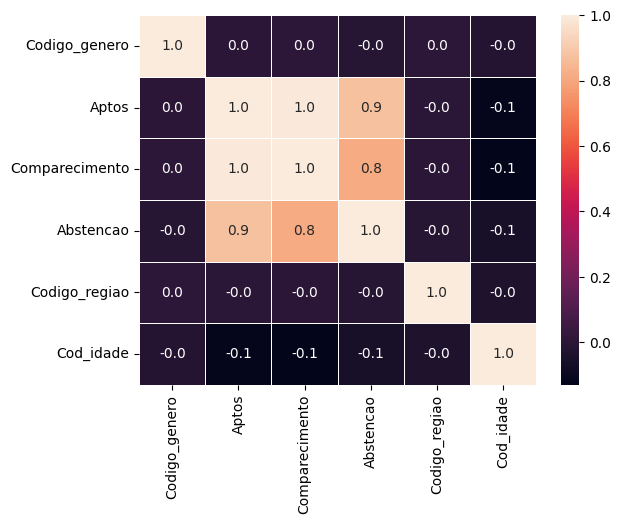

In [28]:
correlation = tb_eleicoes.corr()
plot = sn.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot

### Atributos com uma correlação positiva:

- numero de aptos vs abestenção: 0,9;
- numero de aptos vs comparecimento: 0,8.

### Atributos com uma correlação negativa:

- idade vs aptos, comparecimento e abstenção: -0,1.


Aqui notamos que a idade foi o que mais contribuiu com a ida ou não as urnas, porém temos que considerar entre elas o fator onde parte dos eleitores não possuem obrigatoriedade de votação.


### *Analisando quantidade de abstenção por Região*

<function matplotlib.pyplot.show(close=None, block=None)>

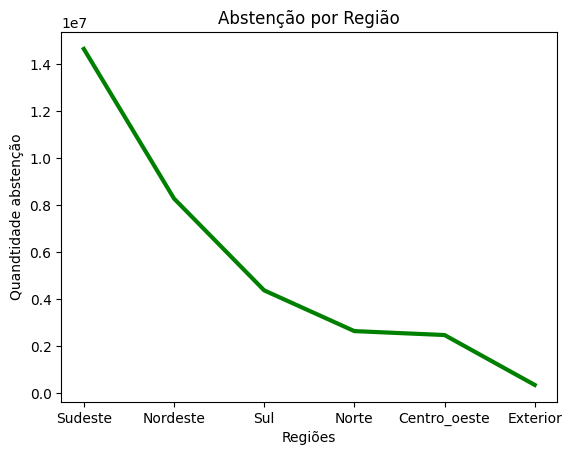

In [29]:
plt.plot(tb_taxaregiao['Regiao'], tb_taxaregiao['Abstencao'], color = 'g', lw=3.0)
plt.ylabel('Quandtidade abstenção')
plt.xlabel('Regiões')
plt.title('Abstenção por Região')
plt.show

Avaliando as abstenções por quantidade de eleitores, vemos aqui que o Sudeste teve a maior quantidade de abstenções seguidas do Nordeste, visto que ambas as regiôes tem a maior quantidade de eleitores, esse gráfico faz sentido.

### *Analisando quantidade de abstenção por Gênero*

<function matplotlib.pyplot.show(close=None, block=None)>

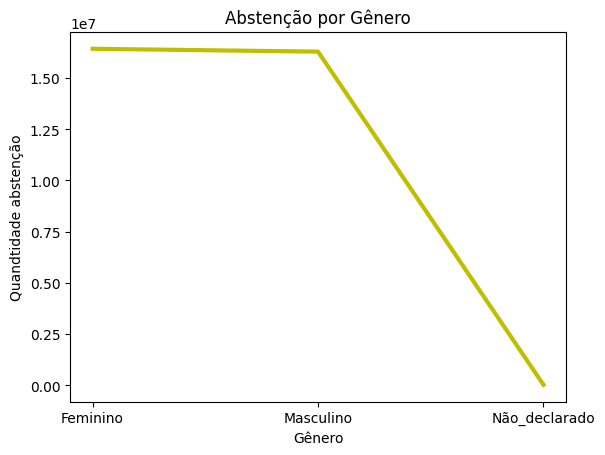

In [30]:
plt.plot(tb_taxagenero['Genero'], tb_taxagenero['Abstencao'], color='y', lw=3.0)
plt.ylabel('Quandtidade abstenção')
plt.xlabel('Gênero')
plt.title('Abstenção por Gênero')
plt.show

Vimos que as mulheres são em maior quantidade de eleitores, porém em abstenções elas se igualam aos homens.

### *Analisando quantidade de abstenção por Faixa Etária*

<function matplotlib.pyplot.show(close=None, block=None)>

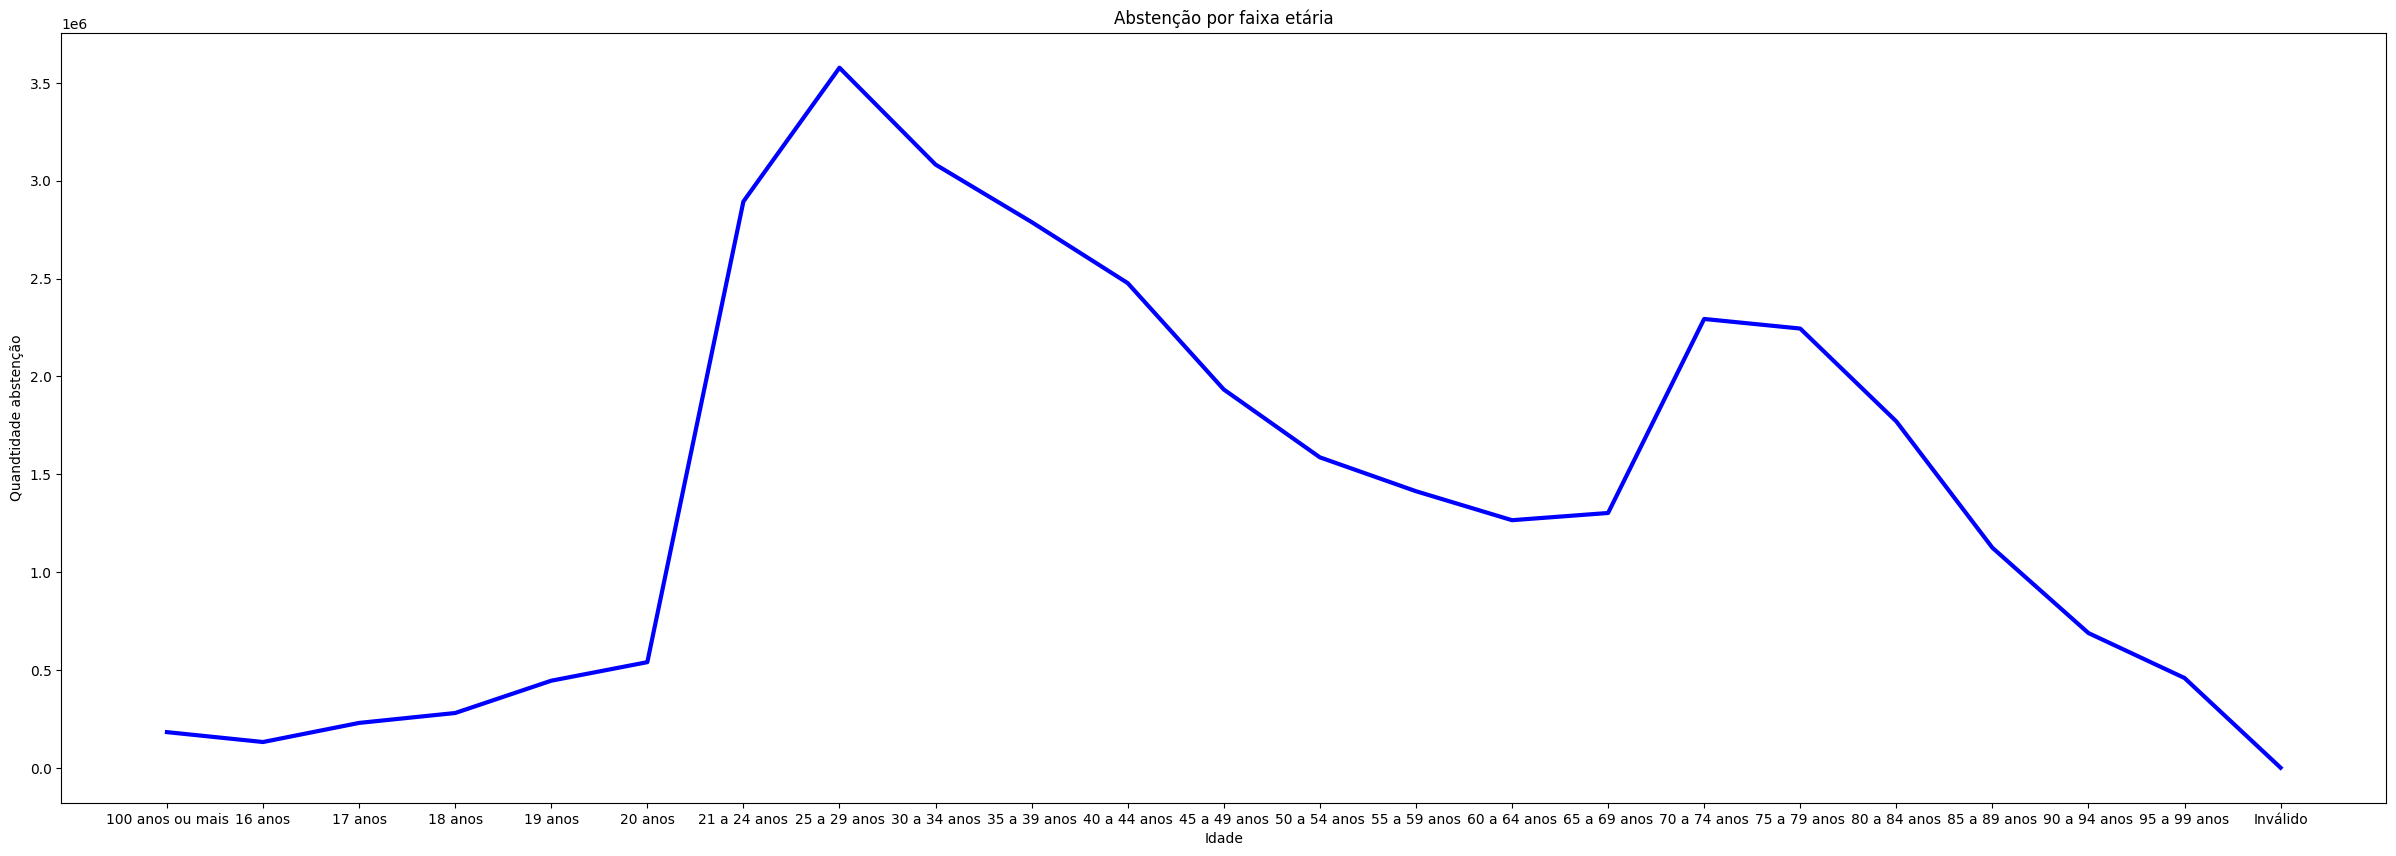

In [31]:
figura = plt.figure(figsize=(30,10))
plt.plot(tb_taxaidade['Faixa_etaria'], tb_taxaidade['Abstencao'], color='b', lw=3.0)
plt.ylabel('Quandtidade abstenção')
plt.xlabel('Idade')
plt.title('Abstenção por faixa etária')
plt.show

Aqui temos a maior quantidade de abstençôes em pessoas que possuem de 25 a 29 anos.

### *Analisando quantidade de abstenção por Escolaridade*

<function matplotlib.pyplot.show(close=None, block=None)>

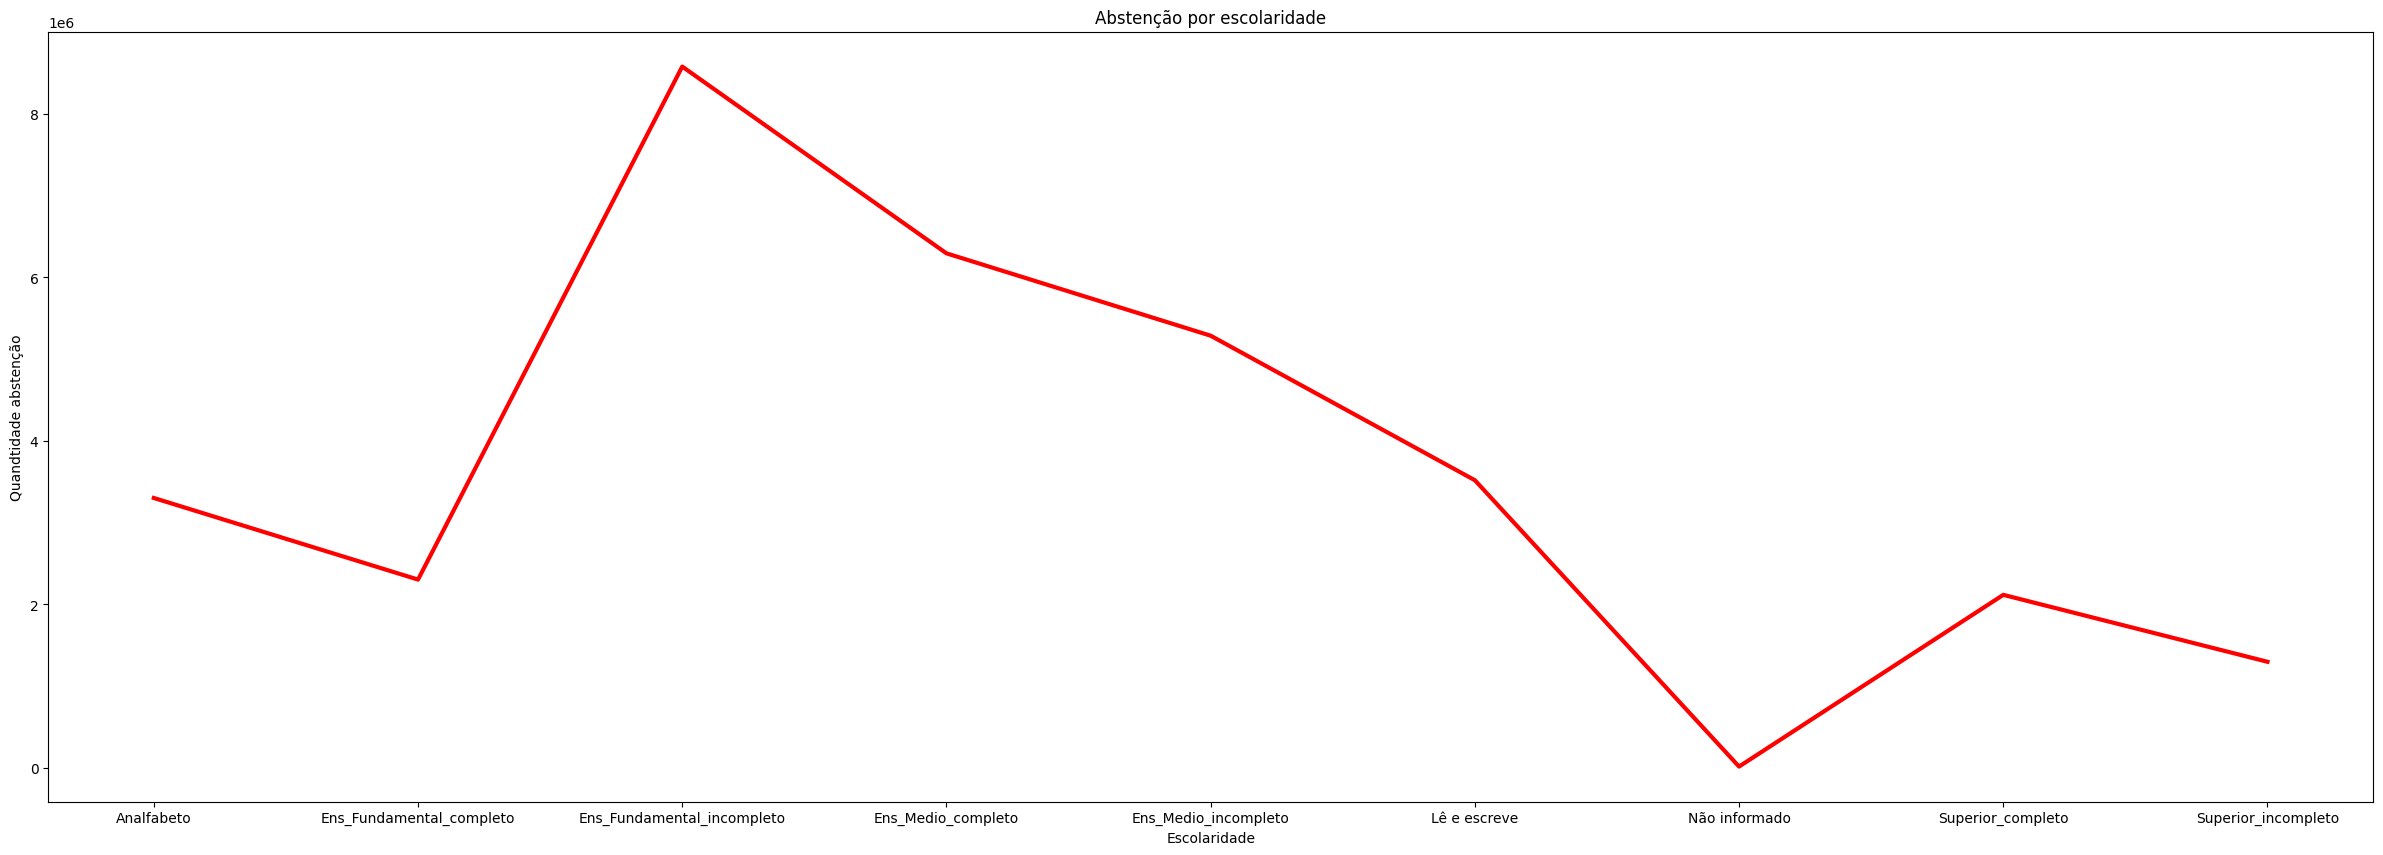

In [32]:
figura = plt.figure(figsize=(30,10))
plt.plot(tb_taxaescolaridade['Escolaridade'], tb_taxaescolaridade['Abstencao'], color='r', lw=3.0)
plt.ylabel('Quandtidade abstenção')
plt.xlabel('Escolaridade')
plt.title('Abstenção por escolaridade')
plt.show

Quem tem ensino fundamental incompleto foram os que mais abstiveram, visto aqui por quantidade.

## FIM